In [70]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- Считывание данных ---
price_df = pd.read_csv("../data/prices/BTC_100ms.csv")         # timestamp, price
adc_df = pd.read_csv("../data/adc/BTC_100ms_w100.csv")             # timestamp, adc
ind_df = pd.read_csv("../data/indicators/BTC_100ms.csv")      # timestamp, rsi, macd, bb_width, volatility, etc.

# --- Слияние по timestamp ---
df = pd.concat([price_df, adc_df, ind_df], axis=1)
df = df.dropna()

# --- Подготовка признаков ---
feature_cols = [c for c in df.columns if c not in ["timestamp", "adc"]]
target_col = "adc"
window_size = 100
horizon = 10  # N-step forecast

# --- Нормализация признаков ---
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# --- Построение X и Y (y — вектор horizon значений вперед) ---
def prepare_multistep_lstm_data(df, feature_cols, target_col, window_size, horizon):
    X, Y = [], []
    data = df[feature_cols + [target_col]].values
    for i in range(window_size, len(data) - horizon):
        x_window = data[i - window_size:i, :-1]
        y_future = data[i + 1 : i + 1 + horizon, -1]
        X.append(x_window)
        Y.append(y_future)
    return np.array(X), np.array(Y)

X, y = prepare_multistep_lstm_data(df, feature_cols, target_col, window_size, horizon)

# --- Разделение на train/test ---
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [71]:
# --- Модель ---
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dense(horizon)
])
model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 212s 24ms/step - loss: 5.3859e-04 - val_loss: 4.0004e-05
Epoch 2/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 208s 24ms/step - loss: 6.7293e-05 - val_loss: 3.7964e-05
Epoch 3/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 209s 24ms/step - loss: 6.5077e-05 - val_loss: 3.9226e-05
Epoch 4/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 210s 24ms/step - loss: 6.4093e-05 - val_loss: 3.7282e-05
Epoch 5/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 209s 24ms/step - loss: 6.4405e-05 - val_loss: 3.8406e-05
Epoch 6/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 211s 24ms/step - loss: 6.3535e-05 - val_loss: 3.7709e-05
Epoch 7/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 209s 24ms/step - loss: 6.3385e-05 - val_loss: 3.7697e-05
Epoch 8/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 213s 24ms/step - loss: 6.4158e-05 - val_loss: 3.7257e-05
Epoch 9/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 212s 24ms/step - loss: 6.2933e-05 - val_loss: 3.7363e-05
Epoch 10/10
8808/8808 ━━━━━━━━━━━━━━━━━━━━ 213s 24ms/step - loss: 6.2529e-05 - val_loss: 3.7360e-05


In [57]:
# --- Прогноз ---
y_pred = model.predict(X_test)

# --- Метрики ---
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2, axis=0))
print("RMSE по каждому горизонту:", np.round(rmse, 6))

sign_accuracy = np.mean(np.sign(y_test) == np.sign(y_pred), axis=0)
print("Sign accuracy per horizon:", np.round(sign_accuracy, 3))

5505/5505 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step
RMSE по каждому горизонту: [0.008848 0.009014 0.009168 0.009314 0.009451 0.009582 0.009707 0.009826
 0.009939 0.010048 0.010153 0.010253 0.010349 0.010438 0.010522 0.010602
 0.010678 0.010752 0.010824 0.010893]
Sign accuracy per horizon: [0.722 0.718 0.713 0.708 0.704 0.7   0.696 0.691 0.687 0.683 0.679 0.675
 0.671 0.667 0.663 0.66  0.656 0.653 0.649 0.646]


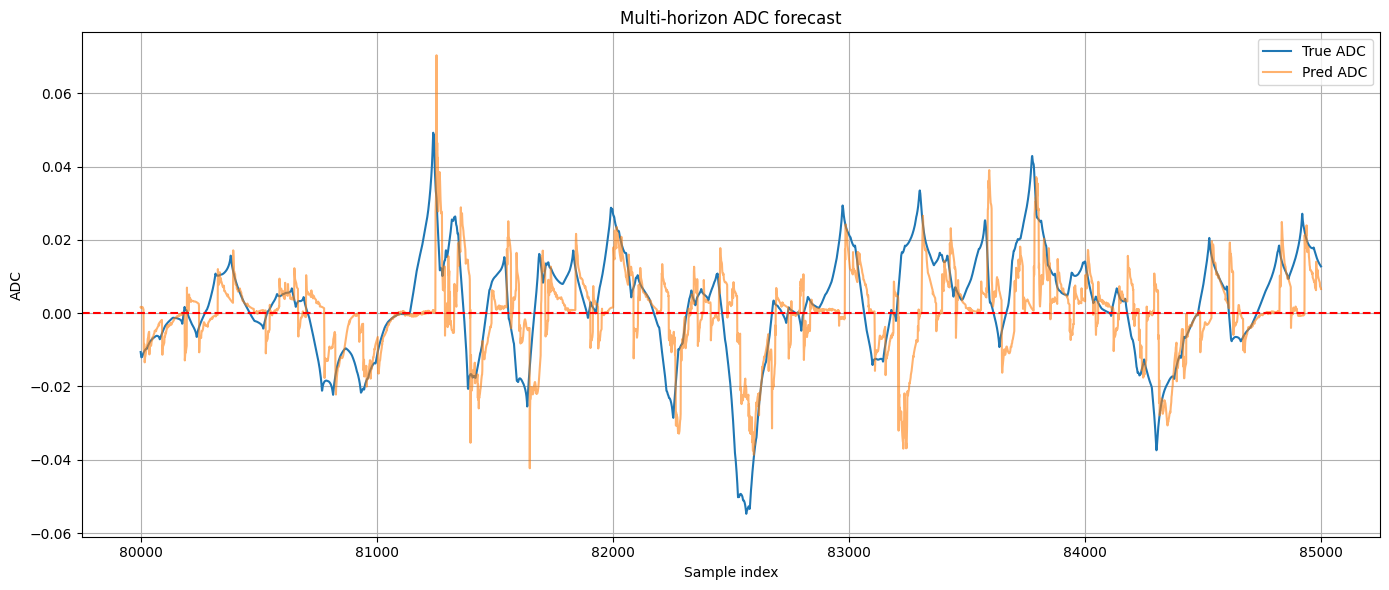

In [75]:
# --- Визуализация (по 4 горизонтам) ---
start = 80000
end = 85000
plt.figure(figsize=(14, 6))
# for h in [0, 2, 4, horizon - 1]:
#     plt.plot(range(start, end), y_test[start:end, h], label=f"True h+{h}")
#     plt.plot(range(start, end), y_pred[start:end, h], label=f"Pred h+{h}", alpha=0.6)
plt.plot(range(start, end), y_test[start:end, 0], label=f"True ADC")
plt.plot(range(start, end), y_pred[start:end, 0], label=f"Pred ADC", alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Multi-horizon ADC forecast")
plt.xlabel("Sample index")
plt.ylabel("ADC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
model.save("../models/mhlstm/lstm_BTC_100ms_w100_GOOD_2.keras")